# Version 1.

In [ ]:
! pip install pycox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from pycox.datasets import metabric
from pycox.models import LogisticHazard
import torch # For building the networks 
import torchtuples as tt # Some useful functions
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [ ]:
csv = pd.read_csv('/content/hack.csv')

In [ ]:
csv

In [ ]:
df_untreated_train = csv[csv.Treatment == 0]
df_treated_train = csv[csv.Treatment == 1]
print(df_untreated_train)
print(df_treated_train)

     G1  G2  G3  G4  G5  G6  ...  Var8  Var9  Var10       time  event  Treatment
0     0   1   0   0   0   0  ...     1     0      1  57.448331      1          0
1     0   1   0   0   0   0  ...     4     0      1  27.004439      1          0
4     0   0   0   0   0   0  ...     3     3      1  44.559284      0          0
6     0   0   0   0   0   0  ...     2     6      2  68.660751      1          0
10    1   0   0   0   0   0  ...     5     1      3  51.667488      0          0
..   ..  ..  ..  ..  ..  ..  ...   ...   ...    ...        ...    ...        ...
991   0   0   0   1   0   1  ...     4     4      2  62.919174      1          0
993   0   1   1   0   0   0  ...     3     1      1  44.302462      1          0
994   0   0   0   0   0   0  ...     4     6      2  19.289036      0          0
997   0   1   0   0   0   0  ...     2     0      7  32.736220      1          0
998   0   0   0   0   0   0  ...     2     1      3  36.714493      1          0

[511 rows x 313 columns]
  

In [ ]:
df_untreated_test = df_untreated_train.sample(frac=0.2)
df_untreated_train = df_untreated_train.drop(df_untreated_test.index)
df_untreated_val = df_untreated_train.sample(frac=0.2)
df_untreated_train = df_untreated_train.drop(df_untreated_val.index)

df_treated_test = df_treated_train.sample(frac=0.2)
df_treated_train = df_treated_train.drop(df_treated_test.index)
df_treated_val = df_treated_train.sample(frac=0.2)
df_treated_train = df_treated_train.drop(df_treated_val.index)

In [ ]:
print(df_untreated_train)

     G1  G2  G3  G4  G5  G6  ...  Var8  Var9  Var10       time  event  Treatment
0     0   1   0   0   0   0  ...     1     0      1  57.448331      1          0
1     0   1   0   0   0   0  ...     4     0      1  27.004439      1          0
6     0   0   0   0   0   0  ...     2     6      2  68.660751      1          0
12    0   0   0   0   0   0  ...     5     0      5  36.172739      1          0
20    0   0   0   0   1   0  ...     0     0      1  36.604778      1          0
..   ..  ..  ..  ..  ..  ..  ...   ...   ...    ...        ...    ...        ...
983   0   0   0   0   0   0  ...     1     1      3  42.732251      1          0
984   0   0   0   1   0   0  ...     2     4      1  40.336502      1          0
991   0   0   0   1   0   1  ...     4     4      2  62.919174      1          0
994   0   0   0   0   0   0  ...     4     6      2  19.289036      0          0
997   0   1   0   0   0   0  ...     2     0      7  32.736220      1          0

[210 rows x 313 columns]


In [ ]:
cols_standardize = ['Var' + str(i) for i in range(1,11)]
cols_leave = ['G' + str(i) for i in range(1,301)]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_untreated_train = x_mapper.fit_transform(df_untreated_train).astype('float32')
x_untreated_val = x_mapper.transform(df_untreated_val).astype('float32')
x_untreated_test = x_mapper.transform(df_untreated_test).astype('float32')

x_treated_train = x_mapper.fit_transform(df_treated_train).astype('float32')
x_treated_val = x_mapper.transform(df_treated_val).astype('float32')
x_treated_test = x_mapper.transform(df_treated_test).astype('float32')

In [ ]:
type(x_untreated_test)

numpy.ndarray

- Duration 가져오는 과정에서 에러 :
- TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'
- 음수 duration 때문인 것 같아서 제거함.


In [ ]:
num_durations = 10

untreated_labtrans = LogisticHazard.label_transform(num_durations)
treated_labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['event'].values)
y_untreated_train = untreated_labtrans.fit_transform(*get_target(df_untreated_train))
y_untreated_val = untreated_labtrans.transform(*get_target(df_untreated_val))

y_treated_train = treated_labtrans.fit_transform(*get_target(df_treated_train))
y_treated_val = treated_labtrans.transform(*get_target(df_treated_val))

untreated_train = (x_untreated_train, y_untreated_train)
untreated_val = (x_untreated_val, y_untreated_val)

treated_train = (x_treated_train, y_treated_train)
treated_val = (x_treated_val, y_treated_val)

# We don't need to transform the test labels
# durations_test, events_test = get_target(df_untreated_test)
untreated_durations_test, untreated_events_test = get_target(df_untreated_test)
treated_durations_test, treated_events_test = get_target(df_treated_test)

In [ ]:
print(untreated_labtrans.cuts)
print(treated_labtrans.cuts)

[  0.          12.15911721  24.31823442  36.47735163  48.63646884
  60.79558606  72.95470327  85.11382048  97.27293769 109.4320549 ]
[  0.          24.11987871  48.23975742  72.35963613  96.47951484
 120.59939356 144.71927227 168.83915098 192.95902969 217.0789084 ]


In [ ]:
print(untreated_labtrans.out_features)

10


In [ ]:
in_features = x_untreated_train.shape[1]
num_nodes = [32, 32]
out_features = untreated_labtrans.out_features
# untreated_out_features = untreated_labtrans.out_features
# treated_out_features = treated_labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, out_features)
)

# treated_net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, treated_out_features)
# )

In [ ]:
untreated_model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=untreated_labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [ ]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [ ]:
untreated_log = untreated_model.fit(x_untreated_train, y_untreated_train, batch_size, epochs, callbacks, val_data=untreated_val)

0:	[0s / 0s],		train_loss: 4.1135,	val_loss: 8.5979
1:	[0s / 0s],		train_loss: 3.3400,	val_loss: 7.8264
2:	[0s / 0s],		train_loss: 2.5323,	val_loss: 7.1825
3:	[0s / 0s],		train_loss: 2.4904,	val_loss: 6.6124
4:	[0s / 0s],		train_loss: 1.5188,	val_loss: 6.1180
5:	[0s / 0s],		train_loss: 1.3304,	val_loss: 5.6960
6:	[0s / 0s],		train_loss: 1.1220,	val_loss: 5.3521
7:	[0s / 0s],		train_loss: 0.8482,	val_loss: 5.0396
8:	[0s / 0s],		train_loss: 0.7003,	val_loss: 4.7858
9:	[0s / 0s],		train_loss: 0.5524,	val_loss: 4.5800
10:	[0s / 0s],		train_loss: 0.4921,	val_loss: 4.4149
11:	[0s / 0s],		train_loss: 0.5428,	val_loss: 4.2805
12:	[0s / 0s],		train_loss: 0.2321,	val_loss: 4.1717
13:	[0s / 0s],		train_loss: 0.2769,	val_loss: 4.0831
14:	[0s / 0s],		train_loss: 0.2525,	val_loss: 4.0003
15:	[0s / 0s],		train_loss: 0.3808,	val_loss: 3.9402
16:	[0s / 0s],		train_loss: 0.0973,	val_loss: 3.8942
17:	[0s / 0s],		train_loss: 0.1022,	val_loss: 3.8477
18:	[0s / 0s],		train_loss: 0.1269,	val_loss: 3.8118
19:

In [ ]:
treated_model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=treated_labtrans.cuts)

In [ ]:
treated_log = treated_model.fit(x_treated_train, y_treated_train, batch_size, epochs, callbacks, val_data=treated_val)

0:	[0s / 0s],		train_loss: 5.0018,	val_loss: 5.6559


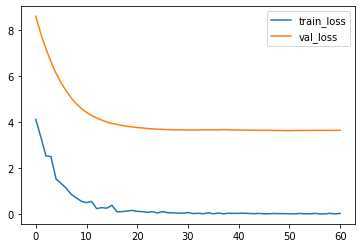

In [ ]:
untreated_log.plot()

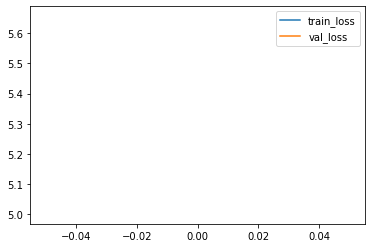

In [ ]:
treated_log.plot()

In [ ]:
log.to_pandas().val_loss.min()

2.591615915298462

In [ ]:
model.score_in_batches(untreated_val)

{'loss': 2.591615915298462}

In [ ]:
surv = model.predict_surv_df(x_untreated_test)

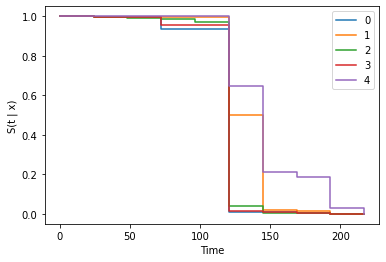

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_untreated_test)

In [ ]:
surv = model.predict_surv_df(x_untreated_train)

In [ ]:
print(surv)

                 0             1         2    ...       207       208           209
0.000000    0.999683  9.998693e-01  0.998708  ...  0.998881  0.999470  9.995924e-01
24.119879   0.998431  9.996136e-01  0.997678  ...  0.996550  0.997853  9.995758e-01
48.239757   0.998165  9.964609e-01  0.997324  ...  0.995537  0.995668  9.336098e-01
72.359636   0.997660  2.114598e-02  0.997311  ...  0.993439  0.776067  9.336097e-08
96.479515   0.997382  1.523528e-04  0.997311  ...  0.993436  0.069130  9.336118e-15
120.599394  0.080730  4.739781e-06  0.997290  ...  0.638343  0.004124  8.250633e-16
144.719272  0.042916  3.781028e-06  0.668582  ...  0.451264  0.000352  8.250382e-16
168.839151  0.022694  1.883523e-06  0.667447  ...  0.415063  0.000253  1.162625e-16
192.959030  0.006923  4.561442e-08  0.035056  ...  0.099532  0.000019  3.527870e-19
217.078908  0.000039  1.832289e-08  0.000016  ...  0.000568  0.000003  3.527803e-19

[10 rows x 210 columns]


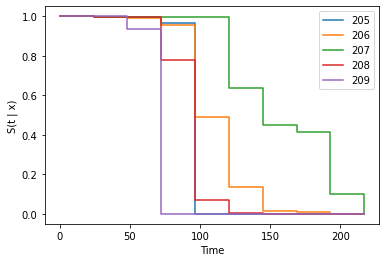

In [ ]:
surv.iloc[:, 205:].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


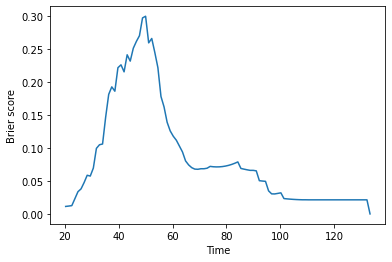

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')